In [1]:
# Imports
import pandas as pd
import numpy as np

from collections import defaultdict
import re
import math

import matplotlib.pyplot as plt
import matplotlib as matplot
from matplotlib import cm
import seaborn as sns
import itertools
import tqdm

%matplotlib inline
# Matplotlib params
plt.rcParams['figure.figsize'] = (16,9)
plt.style.use('ggplot')

# Pandas display options
pd.set_option('display.max_columns',6000)
pd.set_option('display.max_rows',6000)

import numpy as np

from collections import defaultdict

# show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import geopandas as gpd
import shapefile
from shapely.geometry import Point
from shapely.geometry import shape
from pyproj import Proj, transform

# Import

## Load Data

In [3]:
df = pd.read_pickle('Files/Output/activites_for_map_data.pkl')

## Load Geometry

In [5]:
gdf = gpd.read_file('Files/output/activities_for_map_geometry.pkl')

In [6]:
gdf.sample()

id                   geometry
1192  4399  POINT (20.74227 39.08656)

## Import regions - municipalities

In [7]:
reg = gpd.read_file('Files/Output/regions_polygons.pkl')
srg = gpd.read_file('Files/Output/subregions_polygons.pkl')
mun = gpd.read_file('Files/Output/municipalities_polygons.pkl')

# Create interactive map

* Separate markers by region
* Click on municipality and get statistics
* Click on region and get statistics
* Colorpleth maps of municipality/region events

# Set up data

In [9]:
data = defaultdict()

## Events per region

In [10]:
reg_names = pd.read_excel('Files/Shapefiles/Regions_Greek.xlsx')

In [11]:
reg['Name for text'] = reg['Name'].replace(reg_names['NAME'].tolist(),reg_names['ΟΝΟΜΑ'].tolist())

In [15]:
reg['Number of events'] = reg['Name'].apply(lambda x :df.groupby('Region').count().loc[x,'id']).astype('float64')

In [16]:
reg["Text"] = reg.apply(lambda x: x['Name for text'] + '<br><b>' +  str(int(x['Number of events'])) + ' δράσεις</b>',axis=1)

In [17]:
reg_new = reg.copy()

In [18]:
reg_new.sort_values(by='area',ascending = False, inplace=True)

In [19]:
reg_new['id'] = [str(i) for i in reg_new.index] # has to be string

In [20]:
data['Region'] = reg_new

In [21]:
reg_new.head()

Name      area  \
3                Central M  2.008909   
104             Peloponese  1.545785   
0    East Macedonia Thrace  1.462926   
17                Thessaly  1.443754   
100         Central Greece  1.206064   

                                              geometry  \
3    POLYGON ((21.70423 40.86339, 21.73024 40.86859...   
104  POLYGON ((21.56571 37.16195, 21.58845 37.20652...   
0    POLYGON ((23.62358 41.35455, 23.62460 41.37638...   
17   POLYGON ((21.12042 39.67888, 21.15890 39.70056...   
100  POLYGON ((21.37464 39.01890, 21.39441 39.04995...   

                     Name for text  Number of events  \
3               Κεντρική Μακεδονία             218.0   
104                   Πελοπόννησος              91.0   
0    Ανατολική Μακεδονία και Θράκη             132.0   
17                        Θεσσαλία             116.0   
100                  Στερεά Ελλάδα             187.0   

                                                  Text   id  
3             Κεντρική Μακεδονία<br><b>218 δράσεις</b>    3  
104                  Πελοπόννησος<br><b>91 δράσεις</b>  104  
0    Ανατολική Μακεδονία και Θράκη<br><b>132 δράσει...    0  
17                      Θεσσαλία<br><b>116 δράσεις</b>   17  
100                Στερεά Ελλάδα<br><b>187 δράσεις</b>  100

## Events per municipality

In [22]:
mun_names = pd.read_excel('Files/Shapefiles/Dimoi_Greek.xlsx')

In [23]:
mun['Name for text'] = mun['Name'].replace(mun_names['NAME'].tolist(),mun_names['ΟΝΟΜΑ'].tolist())

In [86]:
mun['Name for text'] = mun['Name for text'].apply(lambda x: 'Δήμος ' + x)

In [24]:
mun['Number of events'] = mun['Name'].apply(lambda x :df.groupby('Municipality').count().\
                                            reindex(mun['Name'].unique().tolist(),axis=0).fillna(0).loc[x,'id']).astype('float64')

In [25]:
mun["Text"] = mun.apply(lambda x: x['Name for text'] + '<br><b>' +  str(int(x['Number of events'])) + ' δράσεις</b>',axis=1)

In [26]:
no_event = mun['Number of events'] == 0
mun.loc[no_event,'Text'] = mun.loc[no_event].apply(lambda x: x['Name for text'] + '<br>Περιμένουμε τις όμορφες δράσεις!',axis=1)

In [27]:
one_event = mun['Number of events'] == 1
mun.loc[one_event,'Text'] = mun.loc[one_event].apply(lambda x:  x['Name for text'] + '<br><b>' +  str(int(x['Number of events'])) + ' δράση</b>',axis=1)

In [28]:
mun_new = mun.copy()
mun_new['geometry'] = mun['geometry'].simplify(0.005, preserve_topology=False)

In [29]:
mun_new.sort_values(by='area',ascending = False, inplace=True)

In [30]:
mun_new['id'] = [str(i) for i in mun_new.index] # has to be string

In [31]:
mun_new['Number of events'] = mun_new['Number of events'].replace(0,-30)

In [32]:
data['Municipality'] = mun_new

show this with geojson instead
https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/GeoJSON_and_choropleth.ipynb
Transparency
https://stackoverflow.com/questions/53367522/passing-transparency-style-to-geojson-in-folium

In [33]:
names = {'Region':'Περιφέρειες','Municipality':'Δήμοι'}
marker_widths = {'Region':.5,'Municipality':.001}

# Plot

In [34]:
mapboxt = '----' #my mapbox_access_token

In [35]:
from plotly import graph_objects as go
import json

# Plot

In [36]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

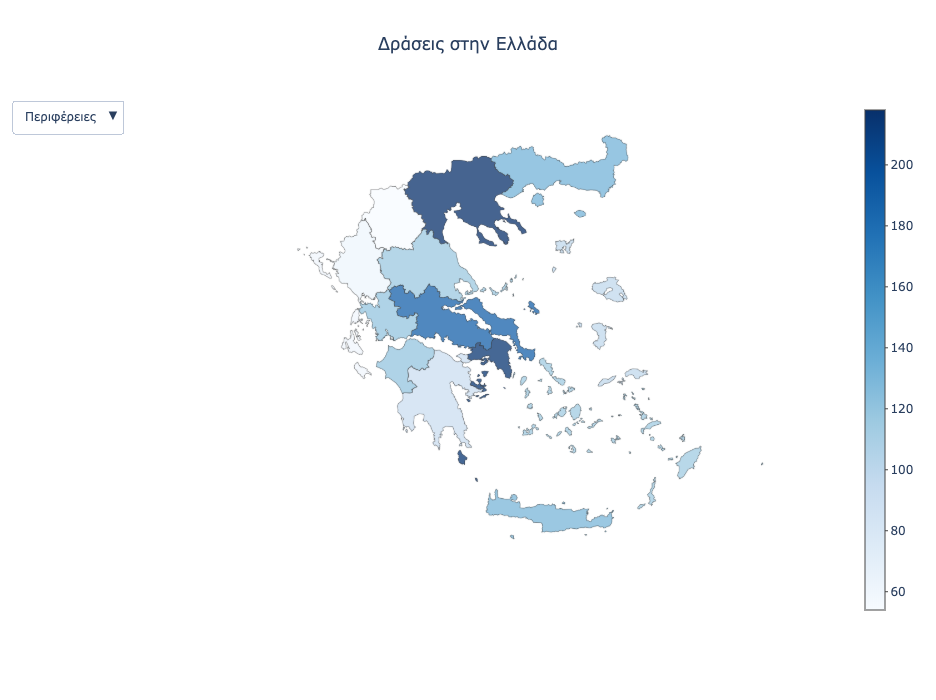

In [40]:
d = data['Region']
geodata = json.loads(d.to_json())
z = d['Number of events']
locations = d['id']
text = d['Text']

fig= go.Figure(go.Choroplethmapbox(z=z,
                            locations=locations,
                            colorscale='blues',
                            colorbar=dict(thickness=20, ticklen=3),
                            geojson=geodata,
                            text = text,
                            marker_line_width=.5, marker_opacity=0.75))

fig.data[0].hovertemplate =  '%{text}<extra></extra>'


# Update menus
list_of_menus = []
for i,c in enumerate(data.keys()):
    i_dict = {'method':'update',
              'label': names[c],
             'name':c,
             'args':[{'z': [data[c]['Number of events']],
                     'locations':[data[c]['id']],
                     'text':[data[c]['Text']],
                     'geojson':[json.loads(data[c].to_json())],
                     'marker_line_width':[marker_widths[c]]}]}
    list_of_menus.append(i_dict)
    
updatemenus = [{'buttons' : list_of_menus,
              'direction': 'down',
              'showactive': True}]
                            
                            
_=fig.update_layout(title_text= 'Δράσεις στην Ελλάδα',
                  title_x=0.5, width = 1200, height=700,
                  mapbox = dict(center= dict(lat=37.964777,  lon=23.799481),
                                 accesstoken= mapboxt,
                                 style='white-bg',
                                 zoom=5,
                               ),
                   updatemenus = updatemenus)

iplot(fig,validate=False, filename='Files/Output/events.html')